**Train ResNet50**

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# ======= PATH ========
dataset_path = '/content/tomatoleaf/clean_tomato_dataset_td'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

save_dir = "/content/drive/MyDrive/train_tomato/ResNet50-GradCAM(Ver2)"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# ======= DATA AUGMENTATION ========
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
image_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

Found 2240 images belonging to 8 classes.
Found 391 images belonging to 8 classes.


In [ ]:
# ======= MODEL ========
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ======= CALLBACKS ========
checkpoint_path = os.path.join(save_dir, 'resnet50_best.weights.h5')
model_path = os.path.join(save_dir, 'resnet50_final.keras')

callbacks = [
    ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
]

In [ ]:
# ======= TRAINING PHASE 1: Train top layers ========
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1515 - loss: 2.3814
Epoch 1: val_accuracy improved from -inf to 0.16113, saving model to /content/drive/MyDrive/train_tomato/ResNet50-GradCAM(Ver2)/resnet50_best.weights.h5
70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 537ms/step - accuracy: 0.1518 - loss: 2.3799 - val_accuracy: 0.1611 - val_loss: 2.0653 - learning_rate: 1.0000e-04
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.1802 - loss: 2.1139
Epoch 2: val_accuracy did not improve from 0.16113
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 432ms/step - accuracy: 0.1803 - loss: 2.1137 - val_accuracy: 0.1611 - val_loss: 2.0317 - learning_rate: 1.0000e-04
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.2209 - loss: 2.0228
Epoch 3: val_accuracy did not improve from 0.16113
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - accuracy: 0.2209 - loss: 2.0227 - val_accuracy: 0.1458 - val_loss: 2.0151 - learning_rate: 1.0000e-04
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/st

In [ ]:
# ======= TRAINING PHASE 2: Unfreeze and Fine-Tune ========
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

model.save(model_path)

Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.1908 - loss: 2.4118
Epoch 1: val_accuracy did not improve from 0.17647
70/70 ━━━━━━━━━━━━━━━━━━━━ 101s 600ms/step - accuracy: 0.1925 - loss: 2.4058 - val_accuracy: 0.1662 - val_loss: 2.3662 - learning_rate: 1.0000e-05
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6028 - loss: 1.2044
Epoch 2: val_accuracy did not improve from 0.17647
70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 513ms/step - accuracy: 0.6034 - loss: 1.2029 - val_accuracy: 0.1662 - val_loss: 4.3587 - learning_rate: 1.0000e-05
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7563 - loss: 0.7645
Epoch 3: val_accuracy did not improve from 0.17647

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - accuracy: 0.7566 - loss: 0.7636 - val_accuracy: 0.1662 - val_loss: 6.4164 - learning_rate: 1.0000e-05
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8661 - 

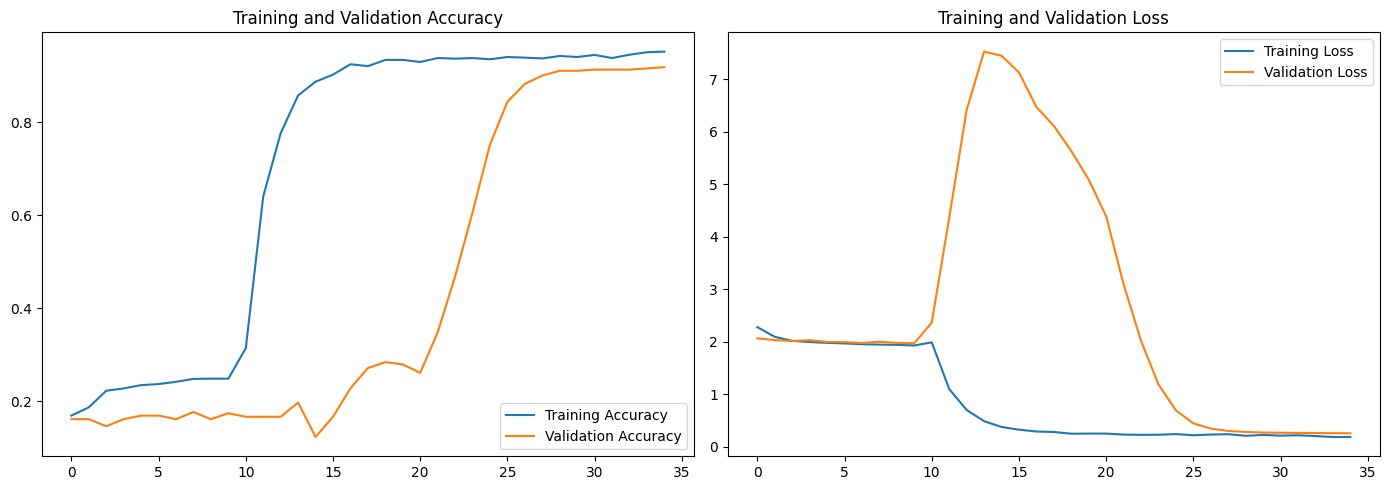

In [ ]:
# ======= Visualize Training ========
def plot_training_history(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history, fine_tune_history)

**Grad-CAM**



In [ ]:
# ======= Load Best Weights ========
model.load_weights(os.path.join(save_dir, 'resnet50_best.weights.h5'))

In [ ]:
# ======= Grad-CAM Function ========
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# ======= Overlay Function ========
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

In [ ]:
# ======= Parameters ========
last_conv_layer_name = 'conv5_block3_out'
image_size = (224, 224)

In [ ]:
# ======= Save Grad-CAM Results ========
gradcam_dir = os.path.join(save_dir, 'gradcam_results')
os.makedirs(gradcam_dir, exist_ok=True)